# Imports

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF

/pfs/data5/home/tu/tu_tu/tu_zxoau27/penv/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## U-Net Model

In [2]:
# double convolutional layer which is executed in every step of the u-net 
# conv layer takes as input number of input channels -> in_channels and outputs vice versa
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # forward pass in the conv layer 
    def forward(self, x):
        return self.conv(x)

# design complete u-net shape 
# model takes as default 3 input channels and 6 output channels
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=6, features=[64, 128, 256, 512],  # features -> num of input nodes at every stage in the model 
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):  # reverse the features i.o. to move upwards in the model 
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # lowest stage in u-net 
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final conv layer: takes in 64 channels and outputs 1 channel by default 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # forward pass of the u-net model between stages 
    def forward(self, x):
        skip_connections = []  # red arrows in the model representation 

        for down in self.downs:
            x = down(x)  # one DoubleConv run-through 
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [3]:
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    print(model)
    preds = model(x)
    assert preds.shape == x.shape

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

## Dataset

In [2]:
import glob

imgs = glob.glob('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/sliced/*tif')
labels = glob.glob("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/sliced/*tif")

# create dictionary -> {key: 'link/to/image_or_label'}
labels_dict = {label.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : label for label in labels}
imgs_dict = {img.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : img for img in imgs}

# check if keys in both dicts are the same 
print(set(imgs_dict) == set(labels_dict))

keys = sorted(list(set(imgs_dict)))
print(keys[:5])

print(labels_dict[keys[0]])
print(imgs_dict[keys[0]])

True
['00_top_potsdam_2_10', '00_top_potsdam_2_11', '00_top_potsdam_2_12', '00_top_potsdam_2_13', '00_top_potsdam_2_14']
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/sliced/00_top_potsdam_2_10_label.tif
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/sliced/00_top_potsdam_2_10_RGB.tif


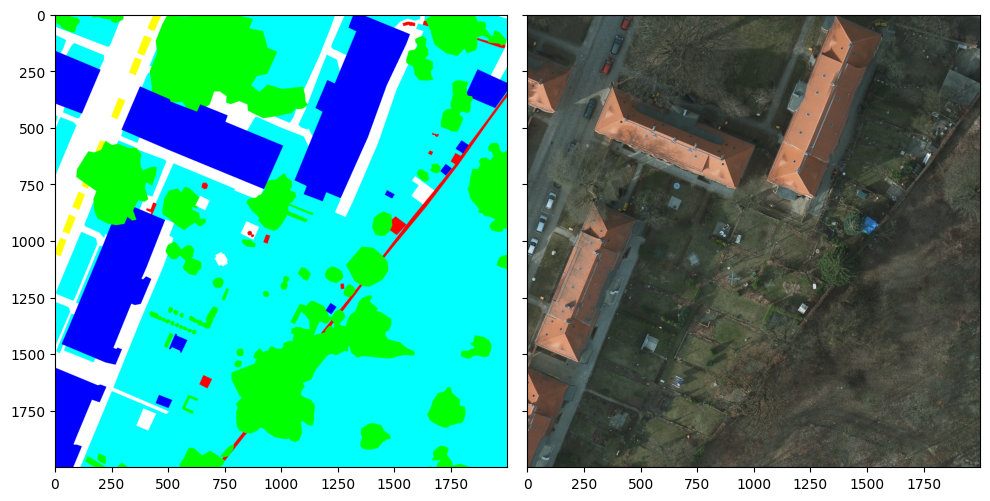

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

im1 = Image.open(labels_dict[keys[0]])
im2 = Image.open(imgs_dict[keys[0]])

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1) 
ax[1].imshow(im2) 

f.tight_layout()
plt.show()

- Impervious surfaces (RGB: 255, 255, 255)      | white 
- Building (RGB: 0, 0, 255)                     | blue 
- Low vegetation (RGB: 0, 255, 255)             | light-blue
- Tree (RGB: 0, 255, 0)                         | green            
- Car (RGB: 255, 255, 0)                        | yellow
- Clutter/background (RGB: 255, 0, 0)           | red

### Custom data set class

In [7]:
# import os
# from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class PotsdamDataset(Dataset):
    def __init__(self, imgs_dict, labels_dict, keys, transform=None):
        self.img_dir = imgs_dict
        self.mask_dir = labels_dict
        self.keys = keys
        self.transform = transform
        
        self.RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB
        
        self.bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_path = self.img_dir[self.keys[idx]]
        mask_path = self.mask_dir[self.keys[idx]]
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        
        cls_mask = np.zeros(mask.shape) # dim: (6000, 6000, 3)
        
        cls_mask[(mask == self.RGB_classes['imprevious']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask[(mask == self.RGB_classes['building']).all(-1)] = self.bin_classes.index('building')
        cls_mask[(mask == self.RGB_classes['low_vegetation']).all(-1)] = self.bin_classes.index('low_vegetation')
        cls_mask[(mask == self.RGB_classes['tree']).all(-1)] = self.bin_classes.index('tree')
        cls_mask[(mask == self.RGB_classes['car']).all(-1)] = self.bin_classes.index('car')
        cls_mask[(mask == self.RGB_classes['background']).all(-1)] = self.bin_classes.index('background')
        cls_mask = cls_mask[:,:,0] # omit last dimension (, , 3) -> RGB  

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=cls_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

#### Testing the class

In [8]:
y = np.array(Image.open(labels_dict[keys[0]]))
x = np.zeros(y.shape)

RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB

bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

x[(y == RGB_classes['imprevious']).all(-1)] = bin_classes.index('imprevious')
x[(y == RGB_classes['building']).all(-1)] = bin_classes.index('building')
x[(y == RGB_classes['low_vegetation']).all(-1)] = bin_classes.index('low_vegetation')
x[(y == RGB_classes['tree']).all(-1)] = bin_classes.index('tree')
x[(y == RGB_classes['car']).all(-1)] = bin_classes.index('car')
x[(y == RGB_classes['background']).all(-1)] = bin_classes.index('background')
x = x[:,:,0]

x[:15, :15]

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3.

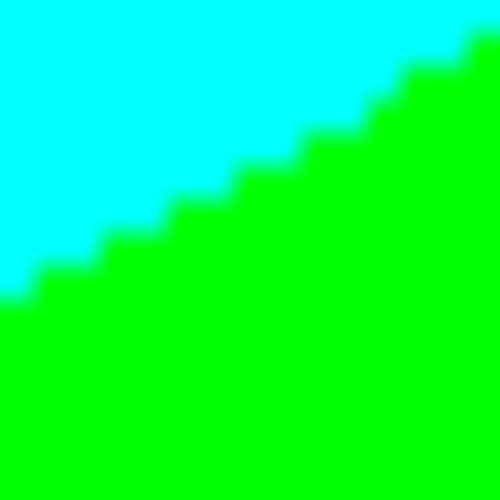

In [10]:
im = Image.open(labels_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 15
bottom = 15

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
 
im1.resize((500, 500))

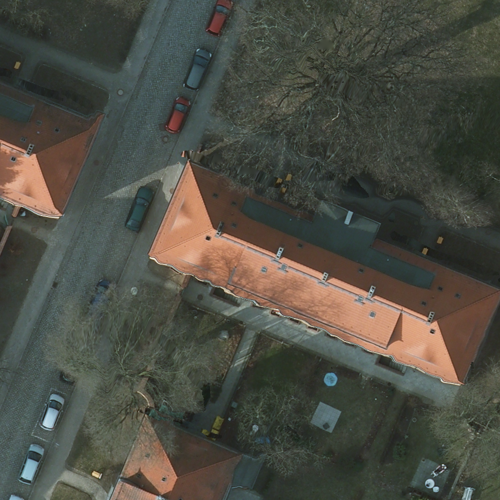

In [13]:
im = Image.open(imgs_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 1000
bottom = 1000

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
im1.resize((500, 500))

## Utils 

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset = PotsdamDataset(imgs_dict, labels_dict, keys)
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [11]:
import torch
import torchvision
# from dataset import PotsdamDataset
from torch.utils.data import DataLoader, random_split


def get_loaders(
    imgs_dict,
    labels_dict,
    keys,
    batch_size,
    train_transform,
    val_transform,
    num_workers = 2,
    pin_memory = True,
):
    
    train_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = train_transform,
    )
    
    valid_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = val_transform,
    )

    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = train_sampler,
    )

    val_loader = DataLoader(
        valid_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = valid_sampler
    )

    return train_loader, val_loader


def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            # compute probabilities
            probs = torch.nn.Softmax(model(x))
            # get predictions by choosing highest probability 
            preds = torch.argmax(probs.dim, axis=1).cpu()
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)
            
            print(num_correct, num_pixels)

    print(
        f"Got {num_correct}/{num_pixels} pixels correct with acc {num_correct/num_pixels*100:.2f}"
    )
    
    
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


# def save_predictions_as_imgs(
#     loader, model, folder="saved_images/", device="cuda"
#     ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             probs = torch.nn.Softmax(model(x))
#             preds = torch.argmax(probs.dim, axis=1).cpu()
#         torchvision.utils.save_image(
#             preds, f"{folder}/pred_{idx}.png"
#         )
#         torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

#     model.train()

## Training

In [12]:
# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_predictions_as_imgs,
# )

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 1000  # 6000 originally
IMAGE_WIDTH = 1000  # 6000 originally
PIN_MEMORY = True
LOAD_MODEL = False
DICT_IMGS = imgs_dict
LABELS_DICT = labels_dict
KEYS = keys


def train_fn(loader, model, optimizer, loss_fn, scaler):
    
    model.train()
    loop = tqdm(loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device=DEVICE)
        targets = targets.type(torch.LongTensor).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    
    train_transform = A.Compose(
        [
            #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.RandomCrop(width=500, height=500, always_apply=True),
            A.Crop(0, 0, 500, 500, always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
    )

    val_transform = A.Compose(
        [
            #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Crop(0, 0, 500, 500, always_apply=True),
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=6).to(device=DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(device=DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        DICT_IMGS, 
        LABELS_DICT,
        KEYS, 
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    # check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"Start epoch: {epoch+1}")
        
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)
        
        print(f"End epoch: {epoch+1} \n")

        # # print some examples to a folder
        # save_predictions_as_imgs(
        #     val_loader, model, folder="saved_images/", device=DEVICE
        # )


In [ ]:
main()